Using device: cuda
Epoch [1/100], Train Loss: 0.0157, Val Loss: 0.0130
Epoch [2/100], Train Loss: 0.0130, Val Loss: 0.0132
Epoch [3/100], Train Loss: 0.0127, Val Loss: 0.0129
Epoch [4/100], Train Loss: 0.0127, Val Loss: 0.0130
Epoch [5/100], Train Loss: 0.0127, Val Loss: 0.0129
Epoch [6/100], Train Loss: 0.0127, Val Loss: 0.0130
Epoch [7/100], Train Loss: 0.0127, Val Loss: 0.0131
Epoch [8/100], Train Loss: 0.0127, Val Loss: 0.0130
Epoch [9/100], Train Loss: 0.0127, Val Loss: 0.0129
Epoch [10/100], Train Loss: 0.0127, Val Loss: 0.0129
Epoch [11/100], Train Loss: 0.0127, Val Loss: 0.0129
Epoch [12/100], Train Loss: 0.0127, Val Loss: 0.0130
Epoch [13/100], Train Loss: 0.0127, Val Loss: 0.0130
Epoch [14/100], Train Loss: 0.0127, Val Loss: 0.0130
Epoch [15/100], Train Loss: 0.0127, Val Loss: 0.0130
Epoch [16/100], Train Loss: 0.0127, Val Loss: 0.0129
Epoch [17/100], Train Loss: 0.0127, Val Loss: 0.0130
Epoch [18/100], Train Loss: 0.0127, Val Loss: 0.0129
Epoch [19/100], Train Loss: 0.0127, 

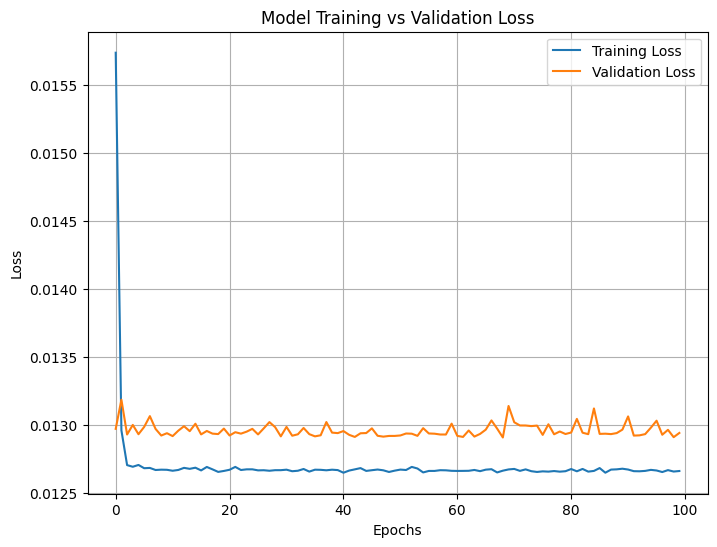

Model Performance: MAE: 0.0903, MSE: 0.0129, R²: 0.1192


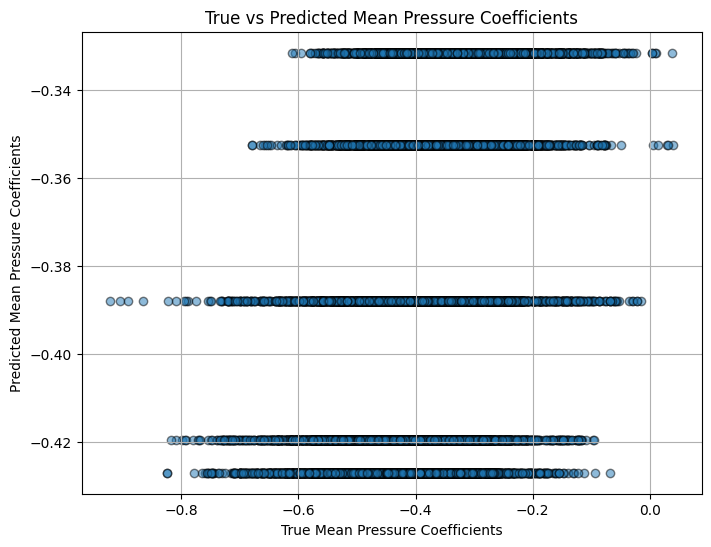

In [1]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.io import loadmat
import matplotlib.pyplot as plt
import seaborn as sns

# Check for GPU availability
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# --- Load and Preprocess Data ---
def load_mat_data(files):
    all_features, all_targets = [], []
    
    for file in files:
        mat_data = loadmat(file)
        wind_pressure_coefficients = mat_data['Wind_pressure_coefficients']
        roof_pitch = mat_data['Roof_pitch'].flatten()
        building_depth = mat_data['Building_depth'].flatten()
        building_breadth = mat_data['Building_breadth'].flatten()
        building_height = mat_data['Building_height'].flatten()
        wind_azimuth = mat_data['Wind_azimuth'].flatten()
        
        mean_pressure_coefficients = wind_pressure_coefficients.mean(axis=1)
        
        num_samples = len(mean_pressure_coefficients)
        features = pd.DataFrame({
            "Roof_pitch": np.tile(roof_pitch, num_samples // len(roof_pitch)),
            "Building_depth": np.tile(building_depth, num_samples // len(building_depth)),
            "Building_breadth": np.tile(building_breadth, num_samples // len(building_breadth)),
            "Building_height": np.tile(building_height, num_samples // len(building_height)),
            "Wind_azimuth": np.tile(wind_azimuth, num_samples // len(wind_azimuth)),
        })
        features["Mean_pressure_coefficient"] = mean_pressure_coefficients
        
        all_features.append(features.drop(columns=["Mean_pressure_coefficient"]))
        all_targets.append(features["Mean_pressure_coefficient"])
    
    return pd.concat(all_features, ignore_index=True), pd.concat(all_targets, ignore_index=True)

# File paths
mat_files = ['../data/Low-rise with eaves/roof type a/height 1;4/Cp_ts_RAH06_deg000.mat','../data/Low-rise with eaves/roof type a/height 1;4/Cp_ts_RAH06_deg023.mat', '../data/Low-rise with eaves/roof type a/height 1;4/Cp_ts_RAH06_deg045.mat', '../data/Low-rise with eaves/roof type a/height 1;4/Cp_ts_RAH06_deg068.mat','../data/Low-rise with eaves/roof type a/height 1;4/Cp_ts_RAH06_deg090.mat']
features, targets = load_mat_data(mat_files)

# Polynomial Features
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(features)
feature_names = poly.get_feature_names_out(features.columns)
poly_df = pd.DataFrame(X_poly, columns=feature_names)
poly_df["Mean_pressure_coefficient"] = targets

# Train-Test Split
X = poly_df.drop(columns=["Mean_pressure_coefficient"])
y = poly_df["Mean_pressure_coefficient"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- Neural Network Model ---
class AeroDataset(Dataset):
    def __init__(self, features, targets):
        self.features = torch.tensor(features, dtype=torch.float32).to(device)
        self.targets = torch.tensor(targets, dtype=torch.float32).to(device)

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

train_dataset = AeroDataset(X_train_scaled, y_train.values)
test_dataset = AeroDataset(X_test_scaled, y_test.values)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class AeroModel(nn.Module):
    def __init__(self, input_size):
        super(AeroModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.dropout = nn.Dropout(0.3)
        self.fc4 = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.dropout(torch.relu(self.fc3(x)))
        return self.fc4(x)

model = AeroModel(input_size=X_train_scaled.shape[1]).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 100
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    for features, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs.squeeze(), targets)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    train_losses.append(epoch_loss / len(train_loader))
    
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for features, targets in test_loader:
            outputs = model(features)
            val_loss += criterion(outputs.squeeze(), targets).item()
    val_losses.append(val_loss / len(test_loader))
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

# Plot Training vs Validation Loss
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Model Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

# Evaluate Model
y_pred = []
y_true = []
model.eval()
with torch.no_grad():
    for features, targets in test_loader:
        outputs = model(features)
        y_pred.append(outputs.squeeze().cpu().numpy())
        y_true.append(targets.cpu().numpy())

y_pred = np.concatenate(y_pred)
y_true = np.concatenate(y_true)

mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"Model Performance: MAE: {mae:.4f}, MSE: {mse:.4f}, R²: {r2:.4f}")

# Scatter Plot
plt.figure(figsize=(8, 6))
plt.scatter(y_true, y_pred, alpha=0.5, edgecolor='k')
plt.xlabel("True Mean Pressure Coefficients")
plt.ylabel("Predicted Mean Pressure Coefficients")
plt.title("True vs Predicted Mean Pressure Coefficients")
plt.grid(True)
plt.show()
